## Imports and Setup

In [11]:

#pip3 install pandas sklearn numpy matplotlib mfc_video_utils sk-video mlxtend
#pip3 install tqdm

%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import sklearn
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
#import seaborn as sns
%aimport mfc_video_utils
from mfc_video_utils import MfcVideoProcessor, BasicTransformer, compute_roc, save_object, load_object, grid_search_forest, grid_search_svm

pd.options.display.max_columns = 500
pd.options.display.max_rows = 2000
#sns.set(rc={"figure.figsize": (12, 8)})
%matplotlib inline
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


UsageError: Line magic function `%%time` not found.


## Load data

In [12]:
%%time
at_polimi = False
if at_polimi:
    datasets_location = Path("/nas/public/dataset/medifor/")
else:
    datasets_location = Path("/data1/dgueraco/datasets/")

CPU times: user 20 µs, sys: 6 µs, total: 26 µs
Wall time: 29.1 µs


In [13]:
%%time
# datasets = [nc2017_dev, mfc18_dev1, mfc18_dev2, mfc18_eval, mfc18_gan, mfc19_val]
if os.path.isfile("datasets.pkl"):
    nc2017_dev, mfc18_dev1, mfc18_dev2, mfc18_eval, mfc18_gan, mfc19_val = load_object("datasets.pkl")
else:
    nc2017_dev = MfcVideoProcessor("nc2017_dev", datasets_location / "NC2017_Dev_Ver1", ref_avail=True)     ## nc2017 - dev (training)
    mfc18_dev1 = MfcVideoProcessor("mfc18_dev1", datasets_location / "MFC18_Dev1_Video_Ver2", ref_avail=True) ## mfc18 - dev1 (training)
    mfc18_dev2 = MfcVideoProcessor("mfc18_dev2",  datasets_location / "MFC18_Dev2_Video_Ver3", ref_avail=True) ## mfc18 - dev2 (training)
    mfc18_eval = MfcVideoProcessor("mfc18_eval", datasets_location / "MFC18_EvalPart1_Video_Ver1", ref_avail=True, ref_folder=True) ## mfc18 - eval (training?)
    mfc18_gan = MfcVideoProcessor("mfc18_gan", datasets_location / "MFC18_Eval_GAN_Video_Ver3", ref_avail=True, ref_folder=True) # mfc18 - gan (training?)
    mfc19_val = MfcVideoProcessor("mfc19_val", datasets_location /  "MFC19_Video_Validation_Ver1", ref_avail=True) # mfc19 - val (test)
    datasets = [nc2017_dev, mfc18_dev1, mfc18_dev2, mfc18_eval, mfc18_gan, mfc19_val]
    save_object(datasets, "datasets.pkl")    

CPU times: user 23.3 ms, sys: 3.72 ms, total: 27 ms
Wall time: 26.4 ms


In [14]:
%%time
print(nc2017_dev.csv["IsTarget"].value_counts())
print(mfc18_dev1.csv["IsTarget"].value_counts())
print(mfc18_dev2.csv["IsTarget"].value_counts())
print(mfc18_gan.csv["IsTarget"].value_counts())
print(mfc18_eval.csv["IsTarget"].value_counts())
print(mfc19_val.csv["IsTarget"].value_counts())

N    189
Y     23
Name: IsTarget, dtype: int64
N    108
Y      8
Name: IsTarget, dtype: int64
N    145
Y     86
Name: IsTarget, dtype: int64
N    68
Y    50
Name: IsTarget, dtype: int64
N    713
Y    323
Name: IsTarget, dtype: int64
Y    48
N    13
Name: IsTarget, dtype: int64
CPU times: user 6.22 ms, sys: 0 ns, total: 6.22 ms
Wall time: 5.63 ms


In [15]:
%%time
mfc18_gan.ffprobe_df.iloc[[7,38,46,2],:].transpose()

CPU times: user 1.86 ms, sys: 553 µs, total: 2.41 ms
Wall time: 2.05 ms


7   \
video_@index                                                                            0   
video_@codec_name                                                                    h264   
video_@codec_long_name                          H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10   
video_@profile                                                                       Main   
video_@codec_type                                                                   video   
video_@codec_time_base                                                               0.02   
video_@codec_tag_string                                                              avc1   
video_@codec_tag                                                               0x31637661   
video_@width                                                                         1280   
video_@height                                                                         720   
video_@coded_width                                                                   1280   
video_@coded_height                                                                   720   
video_@has_b_frames                                                                     0   
video_@sample_aspect_ratio                                                            1:1   
video_@display_aspect_ratio                                                          16:9   
video_@pix_fmt                                                                    yuv420p   
video_@level                                                                           31   
video_@chroma_location                                                               left   
video_@refs                                                                             1   
video_@is_avc                                                                        true   
video_@nal_length_size                                                                4.0   
video_@r_frame_rate                                                                  25.0   
video_@avg_frame_rate                                                                25.0   
video_@time_base                                                                  0.00004   
video_@start_pts                                                                        0   
video_@start_time                                                                     0.0   
video_@duration_ts                                                                 944000   
video_@duration                                                                     37.76   
video_@bit_rate                                                                 9076415.0   
video_@bits_per_raw_sample                                                            8.0   
video_@nb_frames                                                                    944.0   
video_disposition_@default                                                              1   
video_disposition_@dub                                                                  0   
video_disposition_@original                                                             0   
video_disposition_@comment                                                              0   
video_disposition_@lyrics                                                               0   
video_disposition_@karaoke                                                              0   
video_disposition_@forced                                                               0   
video_disposition_@hearing_impaired                                                     0   
video_disposition_@visual_impaired                                                      0   
video_disposition_@clean_effects                                                        0   
video_disposition_@attached_pic                                                         0   
video_disposition_@timed_thumbnails                                                     

In [16]:
%%time
mfc18_gan.csv.iloc[[7,38,46,1],:].transpose()

CPU times: user 1.29 ms, sys: 379 µs, total: 1.67 ms
Wall time: 1.62 ms


7   \
TaskID                                                           manipulation   
ProbeFileID                                  0de25de11d34ce389853de672bd7beec   
ProbeFileName                      probe/0de25de11d34ce389853de672bd7beec.mp4   
IsTarget                                                                    N   
ProbeMaskFileName                                                         NaN   
ProbeBitPlaneMaskFileName                                                 NaN   
ProbeBrowserFileName                                                       no   
BaseFileName                       world/0de25de11d34ce389853de672bd7beec.mp4   
BaseBrowserFileName                                                       NaN   
JournalName                                                               NaN   
ProjectDescription                                                        NaN   
ProjectType                                                             video   
JournalSource                                                   World_nonface   
PostprocessCompression                                                     no   
SemanticRepurposing                                                        no   
People                                                                     no   
AntiforensicAddCamFingerprintPRNU                                          no   
AudioClone                                                                 no   
CompositePixelSize                                                         no   
AudioSplice                                                                no   
SeamCarving                                                                no   
ImageCompressionTable                                                      no   
ImageCompression                                                          NaN   
AudioActivity                                                              no   
TemporalOther                                                              no   
AudioVoiceOver                                                             no   
PostprocessCropFrames                                                      no   
AntiforensicAberrationCorrection                                           no   
DataEmbeddingWatermark                                                     no   
AntiforensicCFACorrection                                                  no   
LaunderingSocialMedia                                                      no   
TemporalRemove                                                             no   
AntiforensicOther                                                          no   
AudioOthers                                                                no   
ImageReformat                                                              no   
AudioRemoval                                                               no   
AudioVoiceSwapping                                                         no   
SpatialOther                                                               no   
AntiforensicNoiseRestoration                                               no   
TemporalReorder                                                            no   
SemanticRefabrication                                                      no   
SpatialSplice                                                              no   
SpatialClone                                                               no   
SpatialMovingObject                                                        no   
SpatialRemove                                                              no   
AntiforensicIllumination                                                   no   
LaunderingMedianFiltering                                                  no   
TemporalClone                                                              no   
Recapture                                                                  no   
Mosaicing                

#### (Trainig) Total of videos: 677 | Pristine videos: 510 | Manipulated videos: 167 (24.6% of total) 
#### (Testing) Total of videos: 1097 | Pristine videos: 761 | Manipulated videos: 336 (30.6% of total) 

## SkLearn

In [9]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.metrics import make_scorer, roc_auc_score, recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, average_precision_score
from mlxtend.classifier import EnsembleVoteClassifier
import random
import warnings
warnings.filterwarnings('ignore')
random_seed = 123
np.random.seed(random_seed)
random.seed(random_seed)

CPU times: user 47 µs, sys: 15 µs, total: 62 µs
Wall time: 65.1 µs


In [8]:
%%time
def test_datasets(pipe):
    l = []
    datasets = [nc2017_dev, mfc18_dev1, mfc18_dev2, mfc18_gan, mfc18_eval, mfc19_val]
    for dataset in datasets:
        l.append(compute_roc(dataset.ffprobe_df, dataset.labels, pipe, title=dataset.name, plot=False))
        print(dataset.name+':',l[-1])
    print('Average ROC AUC:', np.mean(l))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 4.77 µs


#### Experiment Results

#### Fair + GAN setup
1. Train: NC2017_DEV + MFC18_DEV1 + MFC18_DEV2 + MFC18_GAN => Splits and select best
2. Test: MFC18_EVAL + MFC19_EVAL

##### Conclusions:
Our performance in MFC18_GAN is obviously better but we lose performance in MFC18_EVAL + MFC19_EVAL

In [17]:
%%time
train_vids = pd.concat([nc2017_dev.ffprobe_df, mfc18_dev1.ffprobe_df, mfc18_dev2.ffprobe_df, mfc18_gan.ffprobe_df], sort=False)
train_labels = nc2017_dev.labels + mfc18_dev1.labels + mfc18_dev2.labels + mfc18_gan.labels
test_vids = pd.concat([mfc18_eval.ffprobe_df, mfc19_val.ffprobe_df], sort=False)
test_labels = mfc18_eval.labels + mfc19_val.labels

CPU times: user 34.2 ms, sys: 0 ns, total: 34.2 ms
Wall time: 35 ms


In [18]:
%%time
forest = RandomForestClassifier(max_depth=3, max_features='sqrt', min_samples_leaf=1,
                                 min_samples_split=2, n_estimators=3, random_state=random_seed,n_jobs=-1)
svm = SVC(C=3, class_weight='balanced', gamma='scale', random_state=random_seed, probability=True)

CPU times: user 36 µs, sys: 10 µs, total: 46 µs
Wall time: 47.9 µs


In [19]:
%%time
bt = mfc_video_utils.BasicTransformer(cat_threshold=None, num_strategy='median', return_df=False)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.58 µs


In [20]:
%%time
ml_pipe_voting = Pipeline([('transformer', bt), 
                           ('ensembler', VotingClassifier(estimators=[('fr', forest), ('s', svm)], voting='soft', n_jobs=-1))])

CPU times: user 67 µs, sys: 20 µs, total: 87 µs
Wall time: 89.6 µs


In [21]:
%%time
ml_pipe_forest = Pipeline([('transformer', bt), 
                           ('forest', RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=1,
                                                             min_samples_split=2, n_estimators=120, random_state=random_seed, n_jobs=-1))])

CPU times: user 81 µs, sys: 24 µs, total: 105 µs
Wall time: 108 µs


In [22]:
%%time
ml_pipe_svm = Pipeline([('transformer', bt), 
                        ('SVM', SVC(C=150, class_weight='balanced', gamma='scale', random_state=random_seed, probability=True))])

CPU times: user 65 µs, sys: 20 µs, total: 85 µs
Wall time: 87.5 µs


In [23]:
%%time
save_object(ml_pipe_forest, 'best_forest_pipe_ganbase.pkl')
save_object(ml_pipe_svm, 'best_svm_pipe_ganbase.pkl')
save_object(ml_pipe_voting, 'best_voting_pipe_ganbase.pkl')

CPU times: user 771 µs, sys: 0 ns, total: 771 µs
Wall time: 768 µs


In [24]:
%%time
gs_forest_10 = grid_search_forest(train_vids, train_labels, 
                               test_vids, test_labels, 
                               ml_pipe_forest,
                               StratifiedShuffleSplit(n_splits=3, test_size=0.9, train_size=None, random_state=random_seed),
                               refit_score='average_precision_score',
                               n_iter=3)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params for average_precision_score
{'transformer__num_strategy': 'median', 'transformer__cat_threshold': None, 'forest__n_estimators': 500, 'forest__min_samples_split': 5, 'forest__min_samples_leaf': 2, 'forest__max_features': 'log2', 'forest__max_depth': 25}
0.6116221698974731

Confusion matrix of Random Forest optimized for average_precision_score on the test data:
     pred_neg  pred_pos
neg       619       107
pos        71       300
CPU times: user 1.39 s, sys: 235 ms, total: 1.63 s
Wall time: 4.42 s


In [25]:
%%time
gs_forest_25 = grid_search_forest(train_vids, train_labels, 
                               test_vids, test_labels, 
                               ml_pipe_forest,
                               StratifiedShuffleSplit(n_splits=4, test_size=0.75, train_size=None, random_state=random_seed),
                               refit_score='average_precision_score',
                               n_iter=4)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best params for average_precision_score
{'transformer__num_strategy': 'median', 'transformer__cat_threshold': None, 'forest__n_estimators': 500, 'forest__min_samples_split': 5, 'forest__min_samples_leaf': 2, 'forest__max_features': 'log2', 'forest__max_depth': 25}
0.7377618070178545

Confusion matrix of Random Forest optimized for average_precision_score on the test data:
     pred_neg  pred_pos
neg       619       107
pos        71       300
CPU times: user 1.45 s, sys: 240 ms, total: 1.69 s
Wall time: 6.15 s


In [26]:
%%time
gs_forest_50 = grid_search_forest(train_vids, train_labels, 
                               test_vids, test_labels, 
                               ml_pipe_forest,
                               StratifiedShuffleSplit(n_splits=10, test_size=0.50, train_size=None, random_state=random_seed),
                               refit_score='average_precision_score',
                               n_iter=10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best params for average_precision_score
{'transformer__num_strategy': 'median', 'transformer__cat_threshold': None, 'forest__n_estimators': 500, 'forest__min_samples_split': 5, 'forest__min_samples_leaf': 2, 'forest__max_features': 'log2', 'forest__max_depth': 25}
0.8191179067162533

Confusion matrix of Random Forest optimized for average_precision_score on the test data:
     pred_neg  pred_pos
neg       619       107
pos        71       300
CPU times: user 1.75 s, sys: 249 ms, total: 2 s
Wall time: 35.9 s


In [27]:
%%time
gs_forest_75 = grid_search_forest(train_vids, train_labels, 
                               test_vids, test_labels, 
                               ml_pipe_forest,
                               StratifiedShuffleSplit(n_splits=10, test_size=0.25, train_size=None, random_state=random_seed),
                               refit_score='average_precision_score',
                               n_iter=10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best params for average_precision_score
{'transformer__num_strategy': 'median', 'transformer__cat_threshold': None, 'forest__n_estimators': 500, 'forest__min_samples_split': 5, 'forest__min_samples_leaf': 2, 'forest__max_features': 'log2', 'forest__max_depth': 25}
0.8221016529532683

Confusion matrix of Random Forest optimized for average_precision_score on the test data:
     pred_neg  pred_pos
neg       619       107
pos        71       300


In [28]:
%%time
gs_svm_10 = grid_search_svm(train_vids, train_labels, 
                               test_vids, test_labels, 
                               ml_pipe_svm,
                               StratifiedShuffleSplit(n_splits=10, test_size=0.9, train_size=None, random_state=random_seed),
                               refit_score='average_precision_score',
                               n_iter=10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best params for average_precision_score
{'transformer__num_strategy': 'median', 'transformer__cat_threshold': None, 'SVM__gamma': 'auto', 'SVM__class_weight': 'balanced', 'SVM__C': 10}
0.6741683622609289

Confusion matrix of SVM optimized for average_precision_score on the test data:
     pred_neg  pred_pos
neg       636        90
pos        28       343


In [29]:
%%time
gs_svm_25 = grid_search_svm(train_vids, train_labels, 
                               test_vids, test_labels, 
                               ml_pipe_svm,
                               StratifiedShuffleSplit(n_splits=10, test_size=0.75, train_size=None, random_state=random_seed),
                               refit_score='average_precision_score',
                               n_iter=10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best params for average_precision_score
{'transformer__num_strategy': 'median', 'transformer__cat_threshold': None, 'SVM__gamma': 'scale', 'SVM__class_weight': 'balanced', 'SVM__C': 200}
0.8041558405865297

Confusion matrix of SVM optimized for average_precision_score on the test data:
     pred_neg  pred_pos
neg       720         6
pos        74       297
CPU times: user 696 ms, sys: 33.7 ms, total: 730 ms
Wall time: 7.4 s


In [41]:
gs_svm_50 = grid_search_svm(train_vids, train_labels, 
                               test_vids, test_labels, 
                               ml_pipe_svm,
                               StratifiedShuffleSplit(n_splits=10, test_size=0.50, train_size=None, random_state=random_seed),
                               refit_score='average_precision_score',
                               n_iter=100)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Best params for average_precision_score
{'transformer__num_strategy': 'median', 'transformer__cat_threshold': None, 'SVM__gamma': 'scale', 'SVM__class_weight': 'balanced', 'SVM__C': 150}
0.8755542495159429

Confusion matrix of SVM optimized for average_precision_score on the test data:
     pred_neg  pred_pos
neg       718         8
pos        71       300


In [42]:
gs_svm_75 = grid_search_svm(train_vids, train_labels, 
                               test_vids, test_labels, 
                               ml_pipe_svm,
                               StratifiedShuffleSplit(n_splits=10, test_size=0.25, train_size=None, random_state=random_seed),
                               refit_score='average_precision_score',
                               n_iter=100)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Best params for average_precision_score
{'transformer__num_strategy': 'median', 'transformer__cat_threshold': None, 'SVM__gamma': 'auto', 'SVM__class_weight': 'balanced', 'SVM__C': 200}
0.9184128883732723

Confusion matrix of SVM optimized for average_precision_score on the test data:
     pred_neg  pred_pos
neg       692        34
pos        70       301


In [106]:
import matplotlib.pyplot as plt
import matplotlib
sns.reset_defaults()
sns.reset_orig()

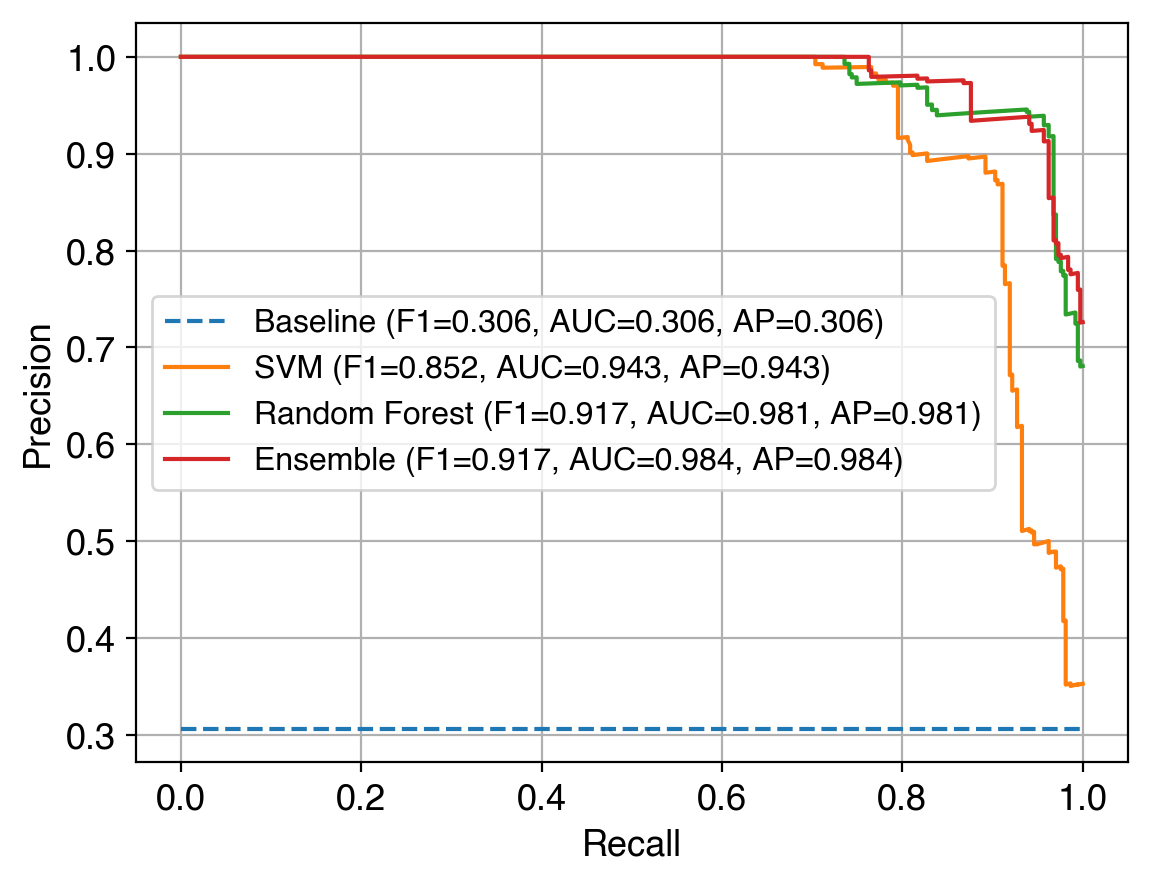

In [129]:
plt.rc('font', family='Helvetica', style='normal', weight='regular', size=13)

# plot no skill
plt.plot([0, 1], [0.306, 0.306], linestyle='--', label='Baseline' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (0.306, 0.306, 0.306))


## SVM
# predict probabilities
probs = gs_svm_10.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_svm_10.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot SVM
plt.plot(recall, precision, label='SVM' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Random Forest
# predict probabilities
probs = gs_forest_10.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_forest_10.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Random Forest
plt.plot(recall, precision, label='Random Forest' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Ensemble
voting_10 = EnsembleVoteClassifier(clfs=[gs_forest_10.best_estimator_, gs_svm_10.best_estimator_], weights=[4,1], refit=False)
voting_10.fit(train_vids, train_labels)
# predict probabilities
probs = voting_10.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = voting_10.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Ensemble
plt.plot(recall, precision, label='Ensemble' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))


# plot the precision-recall curve for the model

plt.xlabel('Recall', fontweight='regular')
plt.ylabel('Precision', fontweight='regular')
plt.legend(loc='best', fontsize=11.5)
plt.grid()

plt.savefig('results_10.pdf',bbox_inches='tight',format='pdf')
plt.show()

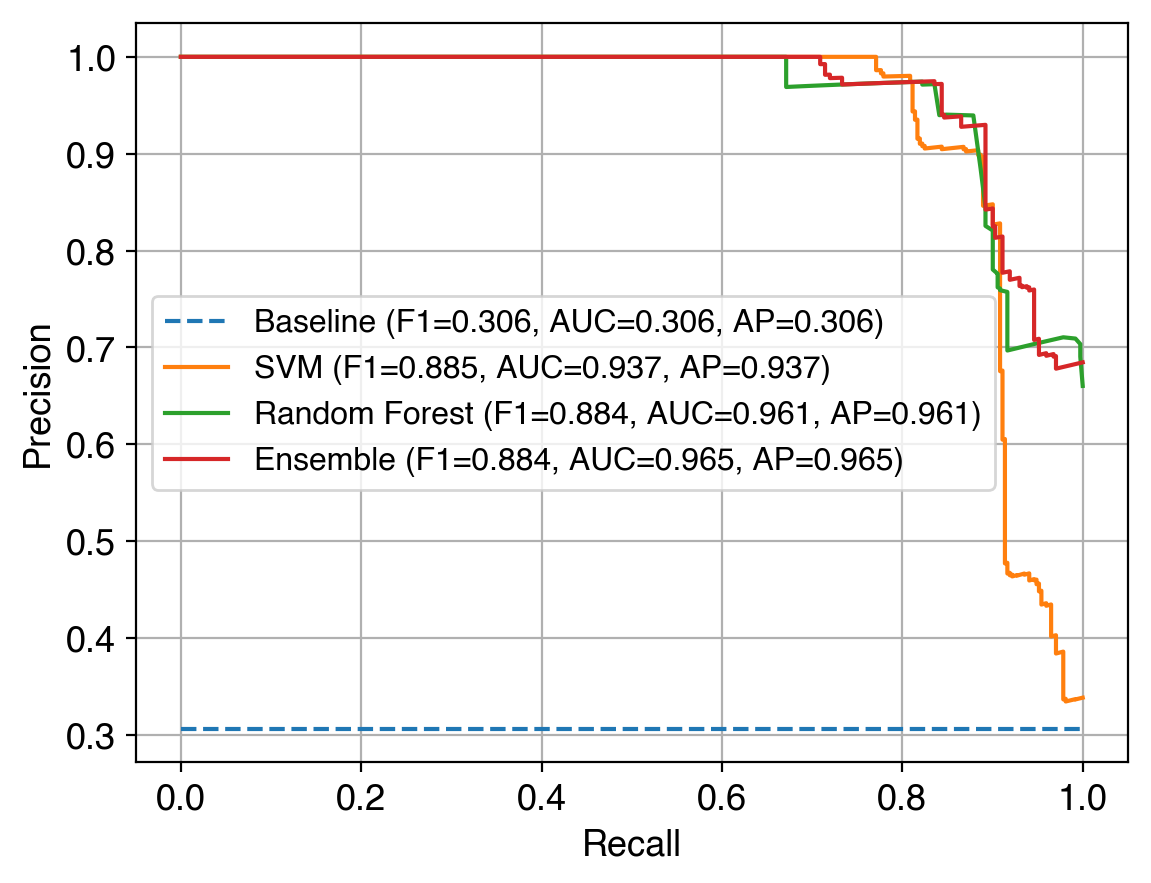

In [130]:
plt.rc('font', family='Helvetica', style='normal', weight='regular', size=13)

# plot no skill
plt.plot([0, 1], [0.306, 0.306], linestyle='--', label='Baseline' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (0.306, 0.306, 0.306))


## SVM
# predict probabilities
probs = gs_svm_25.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_svm_25.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot SVM
plt.plot(recall, precision, label='SVM' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Random Forest
# predict probabilities
probs = gs_forest_25.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_forest_25.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Random Forest
plt.plot(recall, precision, label='Random Forest' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Ensemble
voting_25 = EnsembleVoteClassifier(clfs=[gs_forest_25.best_estimator_, gs_svm_25.best_estimator_], weights=[4,1], refit=False)
voting_25.fit(train_vids, train_labels)
# predict probabilities
probs = voting_25.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = voting_25.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Ensemble
plt.plot(recall, precision, label='Ensemble' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))


# plot the precision-recall curve for the model

plt.xlabel('Recall', fontweight='regular')
plt.ylabel('Precision', fontweight='regular')
plt.legend(loc='best', fontsize=11.5)
plt.grid()


plt.savefig('results_25.pdf',bbox_inches='tight',format='pdf')
plt.show()

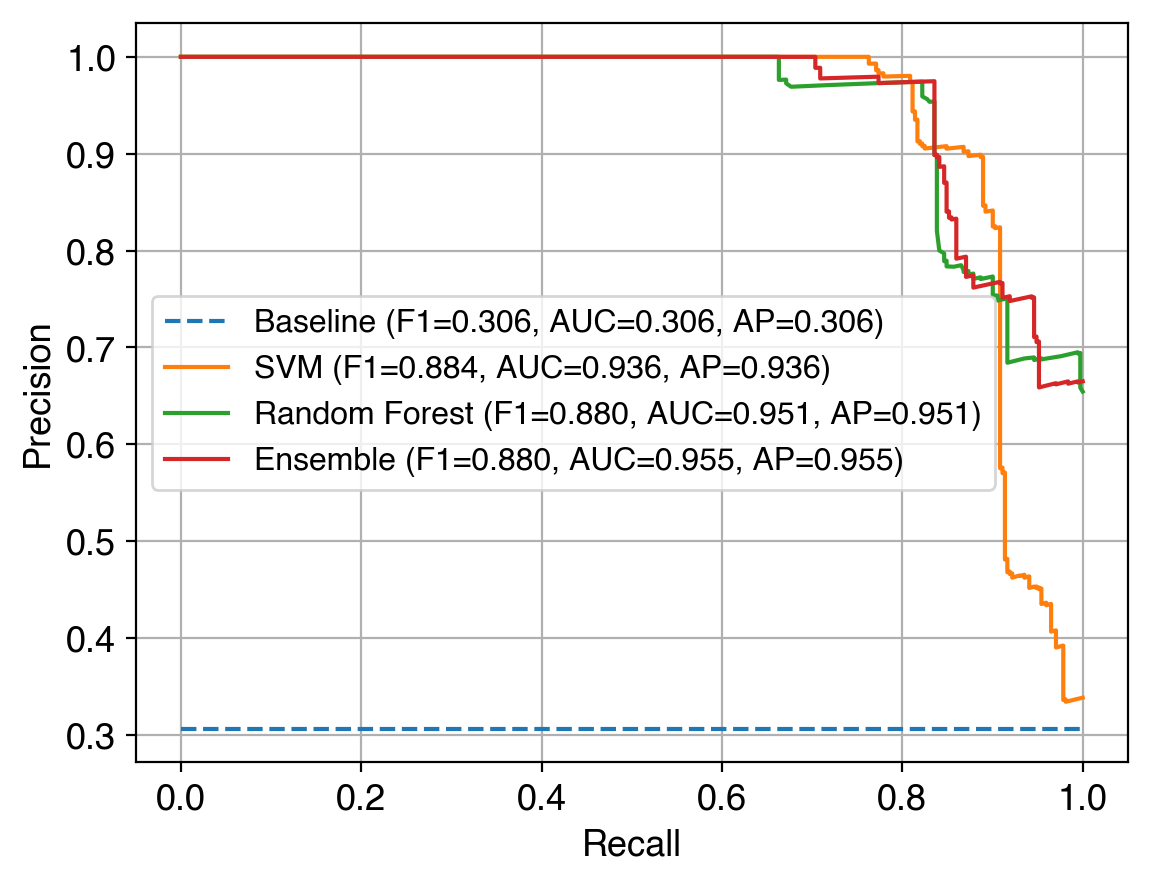

In [131]:
plt.rc('font', family='Helvetica', style='normal', weight='regular', size=13)


# plot no skill
plt.plot([0, 1], [0.306, 0.306], linestyle='--', label='Baseline' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (0.306, 0.306, 0.306))


## SVM
# predict probabilities
probs = gs_svm_50.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_svm_50.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot SVM
plt.plot(recall, precision, label='SVM' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Random Forest
# predict probabilities
probs = gs_forest_50.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_forest_50.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Random Forest
plt.plot(recall, precision, label='Random Forest' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Ensemble
voting_50 = EnsembleVoteClassifier(clfs=[gs_forest_50.best_estimator_, gs_svm_50.best_estimator_], weights=[4,1], refit=False)
voting_50.fit(train_vids, train_labels)
# predict probabilities
probs = voting_50.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = voting_50.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Ensemble
plt.plot(recall, precision, label='Ensemble' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))


# plot the precision-recall curve for the model

plt.xlabel('Recall', fontweight='regular')
plt.ylabel('Precision', fontweight='regular')
plt.legend(loc='best', fontsize=11.5)
plt.grid()


plt.savefig('results_50.pdf',bbox_inches='tight',format='pdf')
plt.show()

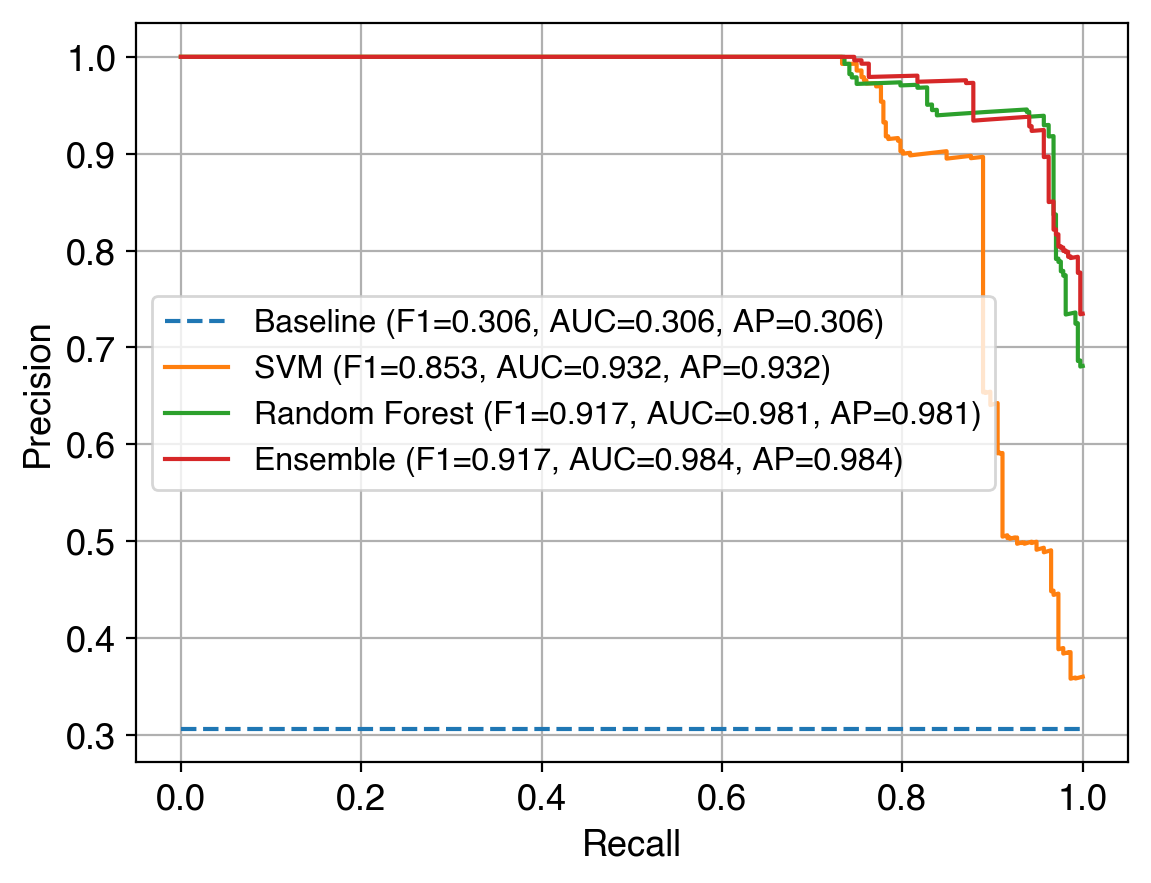

In [132]:
plt.rc('font', family='Helvetica', style='normal', weight='regular', size=13)

# plot no skill
plt.plot([0, 1], [0.306, 0.306], linestyle='--', label='Baseline' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (0.306, 0.306, 0.306))


## SVM
# predict probabilities
probs = gs_svm_75.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_svm_75.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot SVM
plt.plot(recall, precision, label='SVM' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Random Forest
# predict probabilities
probs = gs_forest_75.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = gs_forest_75.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Random Forest
plt.plot(recall, precision, label='Random Forest' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))

## Ensemble
voting_75 = EnsembleVoteClassifier(clfs=[gs_forest_75.best_estimator_, gs_svm_75.best_estimator_], weights=[4,1], refit=False)
voting_75.fit(train_vids, train_labels)
# predict probabilities
probs = voting_75.predict_proba(test_vids)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = voting_75.predict(test_vids)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_labels, probs)
# calculate F1 score
f1 = f1_score(test_labels, yhat)
# calculate precision-recall AUC
auc_num = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_labels, probs)
# plot Ensemble
plt.plot(recall, precision, label='Ensemble' + ' (F1=%.3f, AUC=%.3f, AP=%.3f)' % (f1, auc_num, ap))


# plot the precision-recall curve for the model

plt.xlabel('Recall', fontweight='regular')
plt.ylabel('Precision', fontweight='regular')
plt.legend(loc='center left', fontsize=11.5)
plt.grid()


plt.savefig('results_75.pdf',bbox_inches='tight',format='pdf')
plt.show()

In [98]:
svm_icml = [gs_svm_10.best_estimator_, gs_svm_25.best_estimator_, gs_svm_50.best_estimator_, gs_svm_75.best_estimator_]
forest_icml = [gs_forest_10, gs_forest_25, gs_forest_50, gs_forest_75]
voting_icml = [voting_10, voting_25, voting_50, voting_75]

save_object(svm_icml, 'list_svm_icml.pkl')
save_object(forest_icml, 'list_forest_icml.pkl')
save_object(voting_icml, 'list_voting_icml.pkl')

PicklingError: Can't pickle <class 'mfc_video_utils.BasicTransformer'>: it's not the same object as mfc_video_utils.BasicTransformer